In [13]:
import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd

df = pd.read_csv('./dataset/train.csv')
print(df.shape)  # 输出 (行数, 列数)
print(df.head(5))

(27643, 3)
   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [18]:
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords


import re
from bs4 import BeautifulSoup

# ---- 1) 正文起点：出现就截断其后全部 ----
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)

# ---- 2) 小工具 ----
_MONTH = dict(jan='01',feb='02',mar='03',apr='04',may='05',jun='06',
              jul='07',aug='08',sep='09',oct='10',nov='11',dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    """把任意文本做成 token 安全的 slug（保留 a-z0-9_）"""
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    """数值分桶：edges=[0,1,3,5] -> b0_1, b1_3, b3_5, b5p"""
    if n is None:
        return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h:
        return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h:
        return 'unk'
    area = w*h
    if area <  80_000:  return 'xs'
    if area < 230_000:  return 'sm'     # ~640x360
    if area < 920_000:  return 'md'     # ~1280x720
    if area < 2_100_000:return 'lg'     # ~1920x1080
    return 'xl'

def _parse_wh_from_src(src: str):
    """从 URL 中粗略抓取 .../950x534/... 这样的尺寸"""
    if not src:
        return None, None
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

# ---- 3) 强化版预处理：返回“标题词 + 元特征 token”的一行字符串 ----
def preprocessor(html: str) -> str:
    if not isinstance(html, str):
        html = "" if html is None else str(html)

    # A) 剪掉正文：只保留正文前（页眉/标题区）
    m = _BODY_OPEN.search(html)
    header_html = html[:m.start()] if m else html

    # B) 解析 header_html
    soup = BeautifulSoup(header_html, 'html.parser')

    # 标题（优先 h1.title -> h1 -> <title>）
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1:
        title_raw = h1.get_text(' ', strip=True)
    elif soup.title:
        title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by:
        author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a:
            author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))

    # 频道/类型
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'):
        channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')

    # 发布者
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 时间（年/月/星期/时段/是否周末/季节）
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt)
        if y: year = y.group(1)
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd:
            weekday = wd.group(1).lower()
            is_weekend = weekday in ('sat','sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5<=h<12 else 'afternoon' if 12<=h<17 else 'evening' if 17<=h<22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3<=m_i<=5 else 'summer' if 6<=m_i<=8 else 'autumn' if 9<=m_i<=11 else 'winter'

    # 媒体要素：图片/视频/链接计数 + 画像（主图/分辨率）
    imgs = soup.find_all('img')
    img_count = len(imgs)
    has_image = img_count > 0
    leadimg = soup.find(attrs={'data-fragment':'lead-image'}) is not None

    max_w = max_h = None
    for im in imgs:
        w, h = _parse_wh_from_src(im.get('src', ''))
        if w and h:
            if not max_w or (w*h) > (max_w*max_h if (max_w and max_h) else 0):
                max_w, max_h = w, h
    img_size_bucket  = _img_size_bucket(max_w, max_h)
    img_aspect_bucket = _aspect_bucket(max_w, max_h)

    videos = soup.find_all('video')
    iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)

    link_count = len(soup.find_all('a'))
    link_bucket = _bucket(link_count, [0,1,3,6,10])

    img_bucket  = _bucket(img_count, [0,1,3,5])

    # 标题可传播性特征
    raw = title_raw or ''
    title_has_num      = bool(re.search(r'\d', raw))
    title_has_year     = bool(re.search(r'\b(19|20)\d{2}\b', raw))
    title_has_q        = '?' in raw
    title_has_exclaim  = '!' in raw
    title_has_colon    = ':' in raw
    is_listicle        = bool(re.match(r'^\s*\d+', raw))
    upper_ratio = (sum(ch.isupper() for ch in raw) / max(1, sum(ch.isalpha() for ch in raw)))
    upper_bucket = 'low' if upper_ratio < 0.15 else 'mid' if upper_ratio < 0.4 else 'high'
    title_word_len = len(_norm(raw).split())
    title_char_len = len(re.sub(r'\s+', '', raw))
    tw_bucket = _bucket(title_word_len, [0,4,8,12,20])
    tc_bucket = _bucket(title_char_len, [0,30,60,90,140])

    # 拼接元特征 token（全部小写，确保被 tokenizer 保留）
    feats = []
    # 结构类
    feats += [
        f'author_{author_slug or "unknown"}',
        f'channel_{channel_slug}',
        f'publisher_{publisher_slug}',
        f'year_{year or "unk"}',
        f'month_{month or "unk"}',
        f'weekday_{weekday or "unk"}',
        f'tod_{tod or "unk"}',
        f'season_{season or "unk"}',
        'weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk',
    ]
    # 媒体/链接
    feats += [
        'has_image' if has_image else 'no_image',
        f'imgcnt_{img_bucket}',
        'has_leadimg' if leadimg else 'no_leadimg',
        f'imgsize_{img_size_bucket}',
        f'imgaspect_{img_aspect_bucket}',
        'has_video' if has_video else 'no_video',
        f'linkcnt_{link_bucket}',
    ]
    # 标题形态
    feats += [
        'is_listicle' if is_listicle else 'not_listicle',
        'title_has_num' if title_has_num else 'title_no_num',
        'title_has_year' if title_has_year else 'title_no_year',
        'title_has_q' if title_has_q else 'title_no_q',
        'title_has_exclaim' if title_has_exclaim else 'title_no_exclaim',
        'title_has_colon' if title_has_colon else 'title_no_colon',
        f'title_len_word_{tw_bucket}',
        f'title_len_char_{tc_bucket}',
        f'title_upper_{upper_bucket}',
    ]

    # 最终输出：标题词 + 元特征 token
    parts = []
    if title_tokens:
        parts.append(title_tokens)               # 让 n-gram 学到标题语义
    parts.append(' '.join(feats))                # 元特征
    return ' '.join(parts).strip()


import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text as sk_text

porter = PorterStemmer()
try:
    import nltk
    from nltk.corpus import stopwords as nltk_sw
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    STOP = set(nltk_sw.words('english'))
except Exception:
    STOP = set(sk_text.ENGLISH_STOP_WORDS)

def tokenizer_stem_keepmeta(text):
    toks = re.split(r'\s+', (text or '').strip())
    out = []
    for w in toks:
        if not w:
            continue
        # 元特征（含_或数字）直接保留，不做词干，不做停用词过滤
        if '_' in w or any(ch.isdigit() for ch in w):
            out.append(w)
        else:
            # 纯英文词：去停用词 + 词干
            if w.lower() not in STOP and re.fullmatch(r'[a-zA-Z]+', w):
                out.append(porter.stem(w.lower()))
    return out


In [19]:
# 處理前5行
processed = df['Page content'].head(5).map(preprocessor)

for i, text in enumerate(processed):
    print(f"=== 文本 {i} ===")
    print(text[:500])   # 只打印前500字方便看
    print()

=== 文本 0 ===
nasa s grand challenge stop asteroids from destroying earth author_clara_moskowitz channel_world publisher_space_com year_2013 month_06 weekday_wed tod_afternoon season_summer weekday has_image imgcnt_b1_3 has_leadimg imgsize_md imgaspect_landscape no_video linkcnt_b1_3 not_listicle title_no_num title_no_year title_no_q title_no_exclaim title_has_colon title_len_word_b8_12 title_len_char_b30_60 title_upper_mid

=== 文本 1 ===
google s new open source patent pledge we won t sue unless attacked first author_christina_warren_2013_03_28_17_40_55_utc channel_tech publisher_unknown year_2013 month_03 weekday_thu tod_evening season_spring weekday has_image imgcnt_b1_3 has_leadimg imgsize_md imgaspect_landscape no_video linkcnt_b1_3 not_listicle title_no_num title_no_year title_no_q title_no_exclaim title_has_colon title_len_word_b12_20 title_len_char_b60_90 title_upper_mid

=== 文本 2 ===
ballin 2014 nfl draft picks get to choose their own walk out music author_sam_laird_2014_05_07_1

In [39]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy import sparse as sp
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import text as sk_text
from sklearn.linear_model import SGDClassifier

# ========== 预处理（保持你的函数名，做了稳健性增强） ==========
try:
    import nltk
    from nltk.corpus import stopwords as nltk_sw
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    STOP_WORDS = set(nltk_sw.words('english'))
except Exception:
    # 回退到 sklearn 停用词，避免离线环境崩溃
    STOP_WORDS = set(sk_text.ENGLISH_STOP_WORDS)

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
_emoticon_re = re.compile(r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)')



# ========== 数据流 & 划分 ==========
def get_stream(path, size):
    """按批读取，流式产生 DataFrame；把Popularity从{-1,1}映射到{0,1}。"""
    for chunk in pd.read_csv(path, chunksize=size):
        if 'Popularity' in chunk.columns:
            chunk['Popularity'] = (chunk['Popularity'].astype(int) == 1).astype(int)
        yield chunk

def get_data_streams(path, train_size=20000, val_size=6000, batch_size=500):
    """创建独立的训练与验证流（你的原框架：先整体读，再切分）。"""
    df = pd.read_csv(path)
    df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)

    train_df = df.iloc[:train_size].reset_index(drop=True)
    val_df   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)

    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    return train_generator(), val_generator(), len(train_df), len(val_df)

BATCH_SIZE = 200
TRAIN_SIZE = 26000
VAL_SIZE = 1000

# 使用改进的数据流
TRAIN_PATH = './dataset/train.csv'
train_stream, val_stream, train_size, val_size = get_data_streams(
    TRAIN_PATH, train_size=TRAIN_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE
)


iters = int((TRAIN_SIZE + BATCH_SIZE - 1) / BATCH_SIZE)  # 向上取整


# ========== 向量器（内存友好的 Hashing） ==========
hashvec = HashingVectorizer(
    n_features=2**22,                # 可按内存改 2**19~2**22
    alternate_sign=False,            # PassiveAggressive/SVM 用非负/非负也都可以；NB 必须非负
    ngram_range=(2,3),              # unigram+bigram
    preprocessor=preprocessor,
    tokenizer=tokenizer_stem_keepmeta  
)

def featurize(html_series: pd.Series) -> sp.csr_matrix:
    """一处封装，方便以后换成“词+字符双哈希”等更强特征。"""
    return hashvec.transform(html_series.astype(str))

# ========== 模型 ==========
classes = np.array([0, 1])

# 你现在用的是 PassiveAggressive（与文本流式很配）
clf = SGDClassifier(
    loss="hinge",           # 或 "hinge"
    penalty="elasticnet",
    alpha=1e-6,
    l1_ratio=0.15,
    learning_rate="constant",  # "constant"/"adaptive"/"optimal"/"invscaling"
    eta0= 10000  ,                   # 步长
    average=True,
    max_iter=1, tol=None,
    random_state=42
)

# 如果想切回逻辑回归（SGD），只需改成：
# from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss='log_loss', penalty='elasticnet',
#                     alpha=1e-2, l1_ratio=0.1, average=True,
#                     max_iter=1, tol=None, random_state=42)

# ========== 评估函数：每个iter对“整个验证集”计算AUC ==========
def eval_val_auc_full(clf, val_batches, use_decision_function=True):
    """逐批 featurize、逐批取分数，最后一次性算AUC。"""
    all_scores, all_targets = [], []
    for vb in val_batches:
        Xv = featurize(vb['Page content'])  # ★ 直接用你的双通道 featurize
        if use_decision_function and hasattr(clf, "decision_function"):
            sv = clf.decision_function(Xv)
            scores = sv if sv.ndim == 1 else sv[:, 1]
        else:
            scores = clf.predict_proba(Xv)[:, 1]
        all_scores.append(scores)
        all_targets.append(vb['Popularity'].values)
    y = np.concatenate(all_targets)
    s = np.concatenate(all_scores)
    if np.unique(y).size < 2:
        return np.nan
    return roc_auc_score(y, s)


# ========== 训练循环（加入 Early Stopping + 可选学习率退火） ==========
import copy
train_auc_hist, val_auc_hist = [], []

# 固化验证批次（避免生成器被消耗）
val_batches = list(val_stream)

EVAL_EVERY = 1         # 每步评估一次
PATIENCE = 50           # 早停耐心：验证 AUC 连续多少次无提升就停
MIN_DELTA = 1e-3       # 认为“有提升”的最小幅度
ANNEAL_PATIENCE = 50    # 连续多少次无提升就退火（eta0 *= lr_decay）
LR_DECAY = 0.5         # 学习率衰减倍数
MIN_ETA0 = 1e-5        # 最小 eta0 下限

best_val = -np.inf
best_clf = None
bad_count = 0
since_best = 0

for i in range(iters):
    try:
        # ===== 训练 =====
        train_batch = next(train_stream)
        X_train = train_batch['Page content']
        y_train = train_batch['Popularity'].values

        X_train_vec = featurize(X_train)

        if i == 0:
            clf.partial_fit(X_train_vec, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_vec, y_train)

        # 当前 batch 的训练 AUC（单调分数即可）
        if np.unique(y_train).size == 2:
            train_scores = clf.decision_function(X_train_vec)
            train_auc = roc_auc_score(y_train, train_scores)
        else:
            train_auc = np.nan
        train_auc_hist.append(train_auc)

        # ===== 验证（全量）=====
        if (i + 1) % EVAL_EVERY == 0:
            full_val_auc = eval_val_auc_full(clf, val_batches, use_decision_function=True)
            val_auc_hist.append(full_val_auc)

            improved = full_val_auc > best_val + MIN_DELTA
            if improved:
                best_val = full_val_auc
                best_clf = copy.deepcopy(clf)  # 直接快照整个模型（含平均权重等）
                bad_count = 0
                since_best = 0
            else:
                bad_count += 1
                since_best += 1

                # 可选：学习率退火
                if since_best >= ANNEAL_PATIENCE and clf.learning_rate in ('constant', 'invscaling', 'optimal'):
                    new_eta = max(MIN_ETA0, clf.eta0 * LR_DECAY)
                    if new_eta < clf.eta0:
                        clf.eta0 = new_eta
                    since_best = 0  # 重置退火计数

            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}, "
                  f"Full Val AUC: {full_val_auc:.4f} | "
                  f"best {best_val:.4f} | bad {bad_count}/{PATIENCE} | eta0={clf.eta0:g}")

            # 早停
            if bad_count >= PATIENCE:
                print(f"Early stopping at step {i+1}. Restoring best model with Val AUC={best_val:.4f}.")
                if best_clf is not None:
                    clf = best_clf  # 恢复最佳权重
                break
        else:
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}")

    except StopIteration:
        print("數據流已結束")
        break

# ========== 最终全量验证 ==========
final_val_auc = eval_val_auc_full(clf, val_batches, use_decision_function=True)
print(f"Final Full Val AUC: {final_val_auc:.4f} (best seen {best_val:.4f})")



[1/130] Train AUC: 0.7949, Full Val AUC: 0.4762 | best 0.4762 | bad 0/50 | eta0=10000
[2/130] Train AUC: 0.7786, Full Val AUC: 0.4929 | best 0.4929 | bad 0/50 | eta0=10000
[3/130] Train AUC: 0.7731, Full Val AUC: 0.5178 | best 0.5178 | bad 0/50 | eta0=10000
[4/130] Train AUC: 0.7346, Full Val AUC: 0.5419 | best 0.5419 | bad 0/50 | eta0=10000
[5/130] Train AUC: 0.7456, Full Val AUC: 0.5371 | best 0.5419 | bad 1/50 | eta0=10000
[6/130] Train AUC: 0.6129, Full Val AUC: 0.5315 | best 0.5419 | bad 2/50 | eta0=10000
[7/130] Train AUC: 0.6789, Full Val AUC: 0.5229 | best 0.5419 | bad 3/50 | eta0=10000
[8/130] Train AUC: 0.6363, Full Val AUC: 0.5252 | best 0.5419 | bad 4/50 | eta0=10000
[9/130] Train AUC: 0.6575, Full Val AUC: 0.5309 | best 0.5419 | bad 5/50 | eta0=10000
[10/130] Train AUC: 0.6387, Full Val AUC: 0.5243 | best 0.5419 | bad 6/50 | eta0=10000
[11/130] Train AUC: 0.6330, Full Val AUC: 0.5260 | best 0.5419 | bad 7/50 | eta0=10000
[12/130] Train AUC: 0.6252, Full Val AUC: 0.5256 | b

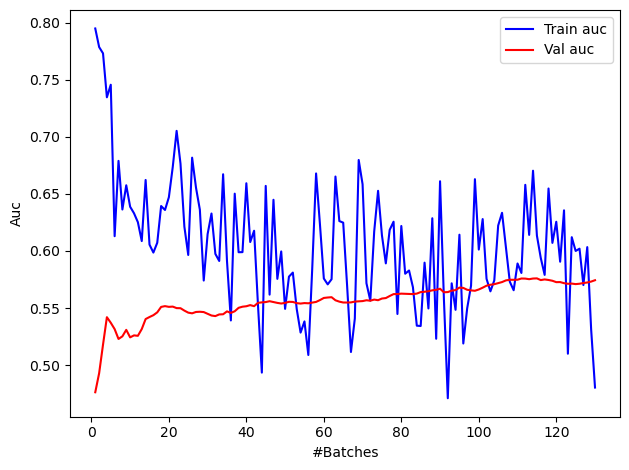

In [40]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc_hist)+1), train_auc_hist, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc_hist), len(val_auc_hist)), 
    val_auc_hist, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

In [45]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./dataset/test.csv')
import scipy as sp
test_pred = sp.special.expit(clf.decision_function(hashvec.transform(df_test['Page content'])))

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
submission.to_csv('output/submission_45.csv', index=False)
print('Test predictions saved to output/submission_45.csv')

Test predictions saved to output/submission_45.csv


In [43]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

df = pd.read_csv('output/submission.csv', usecols=['Id', 'Popularity'])

# Popularity 严格四舍五入到一位小数（ROUND_HALF_UP）
df['Popularity'] = df['Popularity'].map(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))
).astype('float32')

# Id 保持整数（可选）
df['Id'] = df['Id'].astype('int64')

# 写出新文件
df.to_csv('output/submission_45.csv', index=False, float_format='%.1f')
print('saved -> output/submission_45.csv')

saved -> output/submission_45.csv


溫度縮放

In [41]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from decimal import Decimal, ROUND_HALF_UP

# 讀原始提交
df = pd.read_csv('output/submission_30.csv')
col = 'Popularity' if 'Popularity' in df.columns else 'Predicted'

# 1) 溫度縮放：T<1 拉開（0.6~0.9 可調；0.7 通常效果明顯）
T = 1.4
p = df[col].to_numpy(np.float64)
p = np.clip(p, 1e-6, 1-1e-6)          # 防溢出
p_stretch = expit(logit(p) / T)       # 嚴格單調 → 排序不變（AUC 幾乎不變）

# 2) 四捨五入到一位小數（避免銀行家捨入）
def round1_half_up(x):
    return float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))

p_1dp = np.array([round1_half_up(x) for x in p_stretch], dtype=np.float32)
p_1dp = np.clip(p_1dp, 0.0, 1.0)      # 邊界保險

# 3) 輸出：單精度 + 一位小數（減少並列但滿足賽制）
df[col] = p_1dp.astype(np.float32)
df[['Id', col]].to_csv('output/submission_31.csv', index=False, float_format='%.1f')
print('Saved -> output/submission_31.csv')

Saved -> output/submission_31.csv
